In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#from gprofiler import GProfiler
#import loompy as lp
#import rpy2.rinterface_lib.callbacks
import logging
#import scrublet as scr
#from rpy2.robjects import pandas2ri
#import anndata2ri
import warnings
warnings.filterwarnings('ignore')

In [2]:
sc.logging.print_header()

2023-02-09 14:20:08.680746: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-09 14:20:08.684501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-09 14:20:08.684513: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


scanpy==1.10.0.dev26+gd7e13025 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.6


In [3]:
import os              
os.environ['PYTHONHASHSEED'] = '0'
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri

In [4]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

scanpy==1.10.0.dev26+gd7e13025 anndata==0.8.0 umap==0.5.3 numpy==1.21.6 scipy==1.8.0 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.6


In [18]:
adata = sc.read("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Integrated_CD8.h5ad")

In [19]:
adata = adata[adata.obs['desc_0.7'] != 13,: ]

In [6]:
data_clus = adata.obs[['desc_0.3','desc_0.4','desc_0.5','desc_0.6','desc_0.7','desc_0.8']]

In [7]:
data_clus.columns = ['desc_r3_clusters','desc_r4_clusters','desc_r5_clusters',
                     'desc_r6_clusters', 'desc_r7_clusters', 'desc_r8_clusters']

In [9]:
data_clus.to_csv("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/temp.csv",index=True,header=True)
data_clus2 = pd.read_csv("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/temp.csv",index_col=0,header=0)

In [10]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command

old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

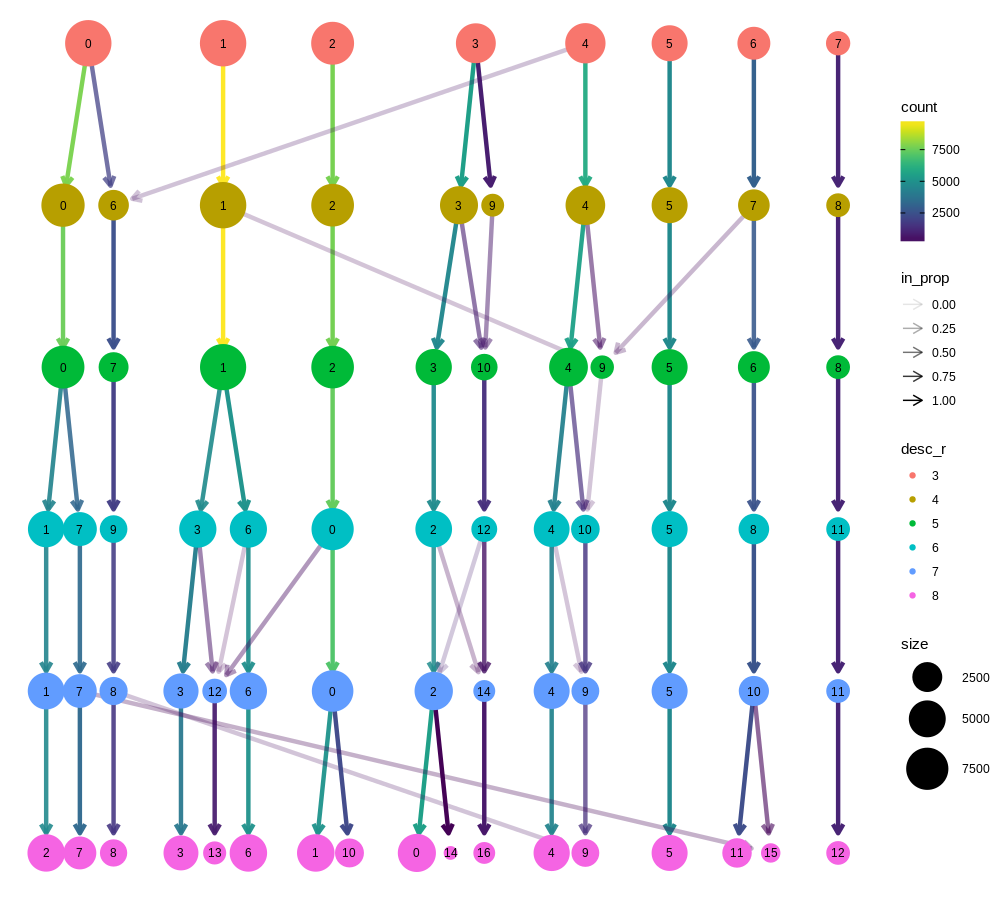

In [11]:
%%R -i data_clus2
library(clustree)

clustree(data_clus2,prefix="desc_r",suffix = "_clusters")

In [12]:
def run_vis(adata):
    if 'X_emb' in adata.obsm:
        sc.pp.neighbors(adata, use_rep='X_emb')
        sc.tl.umap(adata)
    else:
        sc.pp.pca(adata, svd_solver='arpack')
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)

In [20]:
adata.obsm['X_emb'] = adata.obsm['X_Embeded_z'+str(0.4)]
run_vis(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:18)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:36)


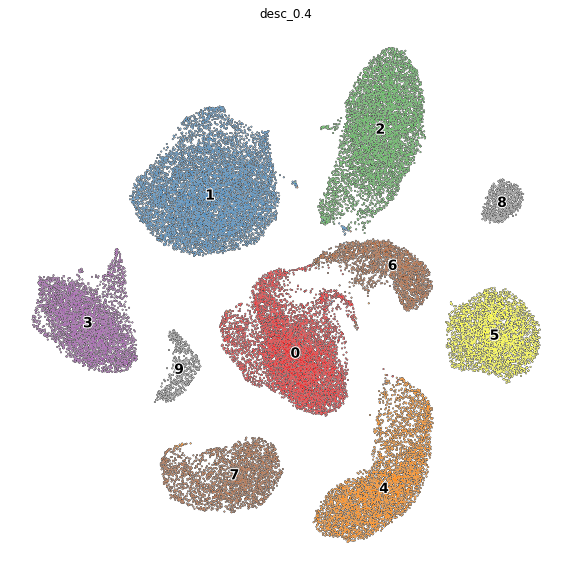

In [55]:
rcParams['figure.figsize'] = 10, 10
sc.pl.umap(adata2, color='desc_0.4', add_outline=True,legend_loc='on data',size=5,
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='desc_0.4', palette='Set1')

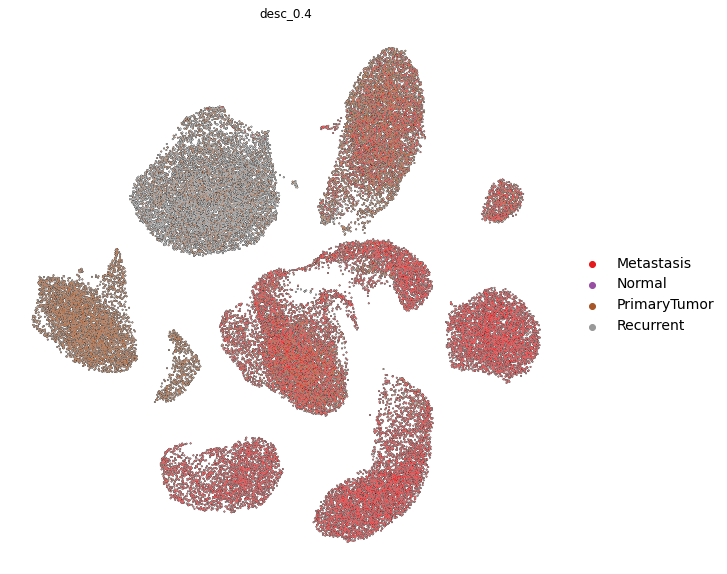

In [56]:
rcParams['figure.figsize'] = 10, 10
sc.pl.umap(adata2, color='Type', add_outline=True,size=5,
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='desc_0.4', palette='Set1')

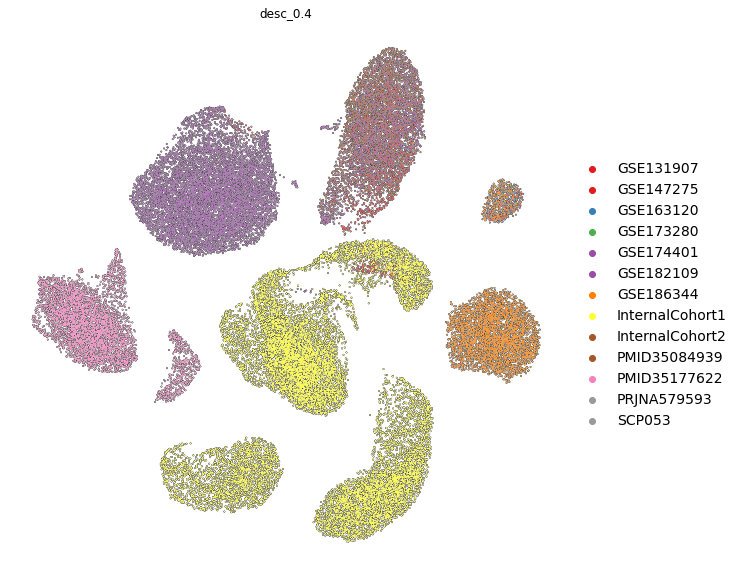

In [57]:
rcParams['figure.figsize'] = 10, 10
sc.pl.umap(adata2, color='Cohort', add_outline=True,size=5,
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='desc_0.4', palette='Set1')

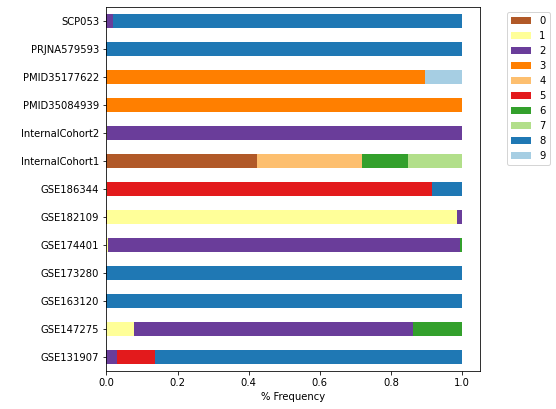

In [58]:
fig, (ax1) = plt.subplots(1,1, figsize=(17/2.54,17/2.54))
ax1 = adata2.obs.groupby("Cohort")["desc_0.4"].value_counts(normalize=True).unstack().plot.barh(stacked=True,legend=False,ax=ax1,colormap='Paired_r')
ax1.set_xlabel("% Frequency")
ax1.set_ylabel(" ")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))

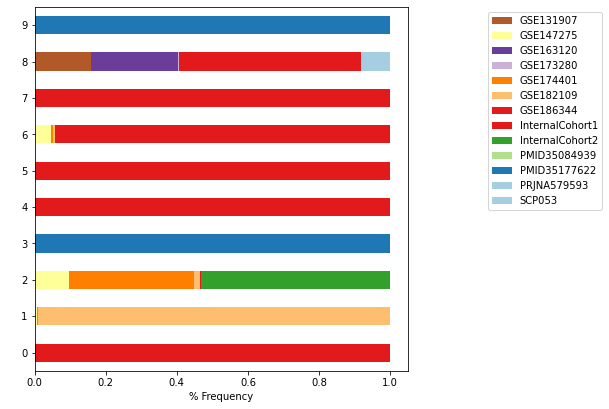

In [59]:
fig, (ax1) = plt.subplots(1,1, figsize=(17/2.54,17/2.54))
ax1 = adata2.obs.groupby("desc_0.4")["Cohort"].value_counts(normalize=True).unstack().plot.barh(stacked=True,legend=False,ax=ax1,colormap='Paired_r')
ax1.set_xlabel("% Frequency")
ax1.set_ylabel(" ")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))

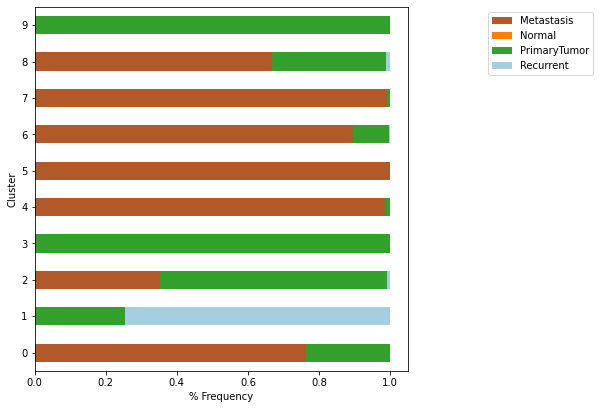

In [60]:
fig, (ax1) = plt.subplots(1,1, figsize=(17/2.54,17/2.54))
ax1 = adata2.obs.groupby("desc_0.4")["Type"].value_counts(normalize=True).unstack().plot.barh(stacked=True,legend=False,ax=ax1,colormap='Paired_r')
ax1.set_xlabel("% Frequency")
ax1.set_ylabel("Cluster")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))

In [38]:
adata.X =  adata.layers['cpm'] 

In [43]:
import celltypist
from celltypist import models

In [44]:
adata.X = adata.layers['raw']
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# logaritmize
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [45]:
model = models.Model.load(model = 'Immune_All_Low.pkl')

In [47]:
predictionsLow = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting = True)

🔬 Input data has 49655 cells and 22976 genes
🔗 Matching reference genes in the model
🧬 5673 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20


running Leiden clustering
    finished: found 299 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:13)


🗳️ Majority voting the predictions
✅ Majority voting done!


In [52]:
pd.DataFrame(predictionsLow.to_adata().obs['predicted_labels'].value_counts()).head(50)

,predicted_labels
Tem/Trm cytotoxic T cells,27168
Regulatory T cells,4998
Tem/Effector helper T cells,4762
Tem/Temra cytotoxic T cells,2225
Type 1 helper T cells,2169
Tcm/Naive helper T cells,1686
Trm cytotoxic T cells,828
MAIT cells,740
CD16- NK cells,563
CRTAM+ gamma-delta T cells,517


In [53]:
adata2 = predictionsLow.to_adata()

In [54]:
adata2 = adata2[adata2.obs['predicted_labels'].isin(['Tem/Trm cytotoxic T cells','Regulatory T cells',
                                    'Tem/Effector helper T cells','Tem/Temra cytotoxic T cells',
                                    'Type 1 helper T cells','Tcm/Naive helper T cells',
                                    'Tcm/Naive cytotoxic T cells','Follicular helper T cells','Cycling T cells']),:]

In [41]:
del adata2.uns['log1p']

In [61]:
sc.tl.rank_genes_groups(adata2, 'desc_0.4', method='wilcoxon',use_raw=False,pts=0.20)
pd.DataFrame(adata2.uns['rank_genes_groups']['names']).head(50)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:55)


,0,1,2,3,4,5,6,7,8,9
0,MTRNR2L12,ATP5F1E,B2M,AC016831.7,SEPTIN7,IGKC,MTRNR2L12,IFITM1,ATP5L,AC016831.7
1,EEF1G,NEAT1,TMSB4X,SIK3,GZMB,IGLC3,RESF1,ATP6V0C,ATP5G2,SIK3
2,ZFP36,FTL,TRAC,ZSWIM6,DUSP4,ATP5E,TNFAIP3,PLAAT4,GNB2L1,ZSWIM6
3,HLA-B,N4BP2L2,MYL12A,ARIH1,IFITM1,IGHG1,ZFP36,PCBP2,ATP5E,DENND4A
4,SNHG29,APOE,RARRES3,ARHGAP15,CTLA4,GNB2L1,CXCL13,GZMB,ATP5G3,TEX14
5,EEF1A1,RACK1,ATP5F1E,DENND4A,ITGAE,GLTSCR2,AHNAK,GAPDH,C19orf43,DOCK4
6,TLE5,TMSB4X,TMSB10,ELL2,PCED1B-AS1,ATP5L,IL7R,HSPA8,TCEB2,ARIH1
7,GAS5,HCST,SEPT7,SIPA1L1,TIGIT,IGLC2,ETS1,ZFP36L2,ATP5J,ZFAND3
8,PLAAT4,JUND,CD3D,PDE3B,RNASEK,S100A6,SFPQ,SNHG29,ATP5D,BTBD9
9,SNHG6,SPP1,ATP5MG,CDC42SE2,IFNG,ATP5G2,RNF19A,EIF4A1,ATP5J2,PLXDC2


In [62]:
result = adata2.uns['rank_genes_groups']

In [63]:
groups = result['names'].dtype.names

In [65]:
pd.DataFrame(
    {group + '_' + key[:3]: result[key][group]
    for group in groups for key in ['names', 'pvals','pvals_adj','logfoldchanges']}).to_csv("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/DEGS_CD8_Res04.csv",header=True,index=False)

In [66]:
groups = result['names'].dtype.names
with pd.ExcelWriter('/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/DEGS_CD8_Res04.xlsx') as writer:
    for _ in range(len(groups)):
        sc.get.rank_genes_groups_df(adata2,
                                    group=groups[_], key='rank_genes_groups',pct=0.20).to_excel(writer, sheet_name=groups[_],index=False)
        

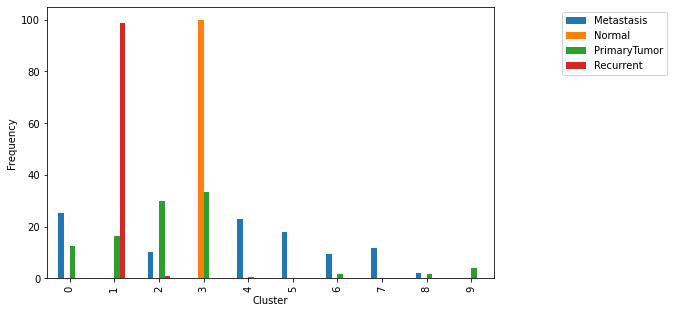

In [71]:
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))
#
ax1 = (pd.crosstab(adata2.obs["desc_0.4"], adata.obs.Type,normalize='columns')*100).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.4, 1.0))

In [72]:
adata2.obs

,SampleID,GEO_RNA,Cohort,Type,Subtype,Diagnosis,Grade,Location,IDH1_Status,EGFR_Status,...,predicted_labels,majority_voting,conf_score,desc_0.3,desc_0.4,desc_0.5,desc_0.6,desc_0.7,desc_0.8,over_clustering
CNSTM_397_4,CNSTM_397,GSM5518626,GSE182109,Recurrent,NotAvailable,Glioblastoma,IV,Left_Temporal,NotAvailable,NotAvailable,...,Tem/Trm cytotoxic T cells,Tem/Trm cytotoxic T cells,0.997998,1,1,1,3,3,3,202
CNSTM_397_13,CNSTM_397,GSM5518626,GSE182109,Recurrent,NotAvailable,Glioblastoma,IV,Left_Temporal,NotAvailable,NotAvailable,...,Type 1 helper T cells,Tem/Trm cytotoxic T cells,0.219646,1,1,1,6,12,13,205
CNSTM_397_25,CNSTM_397,GSM5518626,GSE182109,Recurrent,NotAvailable,Glioblastoma,IV,Left_Temporal,NotAvailable,NotAvailable,...,Tem/Trm cytotoxic T cells,Tem/Trm cytotoxic T cells,0.947245,1,1,1,3,12,3,98
CNSTM_397_34,CNSTM_397,GSM5518626,GSE182109,Recurrent,NotAvailable,Glioblastoma,IV,Left_Temporal,NotAvailable,NotAvailable,...,Type 1 helper T cells,Tem/Trm cytotoxic T cells,0.529322,1,1,1,3,3,13,187
CNSTM_397_35,CNSTM_397,GSM5518626,GSE182109,Recurrent,NotAvailable,Glioblastoma,IV,Left_Temporal,NotAvailable,NotAvailable,...,Tem/Temra cytotoxic T cells,Tem/Trm cytotoxic T cells,0.977874,1,1,1,3,6,3,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6_2102,6,GSM4423291,GSE147275,PrimaryTumor,NotAvailable,Glioblastoma,IV,Right_Temporal,WT,NotAvailable,...,Tcm/Naive helper T cells,Tem/Trm cytotoxic T cells,0.764743,2,2,2,0,12,13,91
6_2108,6,GSM4423291,GSE147275,PrimaryTumor,NotAvailable,Glioblastoma,IV,Right_Temporal,WT,NotAvailable,...,Tcm/Naive helper T cells,Tcm/Naive helper T cells,0.967701,1,6,7,3,12,13,148
6_2109,6,GSM4423291,GSE147275,PrimaryTumor,NotAvailable,Glioblastoma,IV,Right_Temporal,WT,NotAvailable,...,Regulatory T cells,Tcm/Naive helper T cells,0.454805,1,6,7,6,12,13,148
6_2111,6,GSM4423291,GSE147275,PrimaryTumor,NotAvailable,Glioblastoma,IV,Right_Temporal,WT,NotAvailable,...,Tcm/Naive cytotoxic T cells,Tem/Trm cytotoxic T cells,0.368525,2,2,2,0,12,13,111


In [74]:
tmp1 = pd.DataFrame(adata.obs.groupby(["SampleID","Type"])["desc_0.4"].value_counts(normalize=True))

In [75]:
tmp1 = tmp1.rename({'desc_0.4':'desc_0.42'},axis=1)
tmp1.to_csv("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/ptzfreqtreg.csv",sep="\t",index=True,header=True)

In [76]:
tmp2 = pd.read_csv("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/ptzfreqtreg.csv",sep="\t",header=0)

In [77]:
tmp2['merge'] = tmp2['Type'] + "_" + tmp2['Unnamed: 2'].astype(str)

In [78]:
order_agebin = pd.value_counts(tmp2['Unnamed: 2']).sort_index().index

In [79]:
order_agebin

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

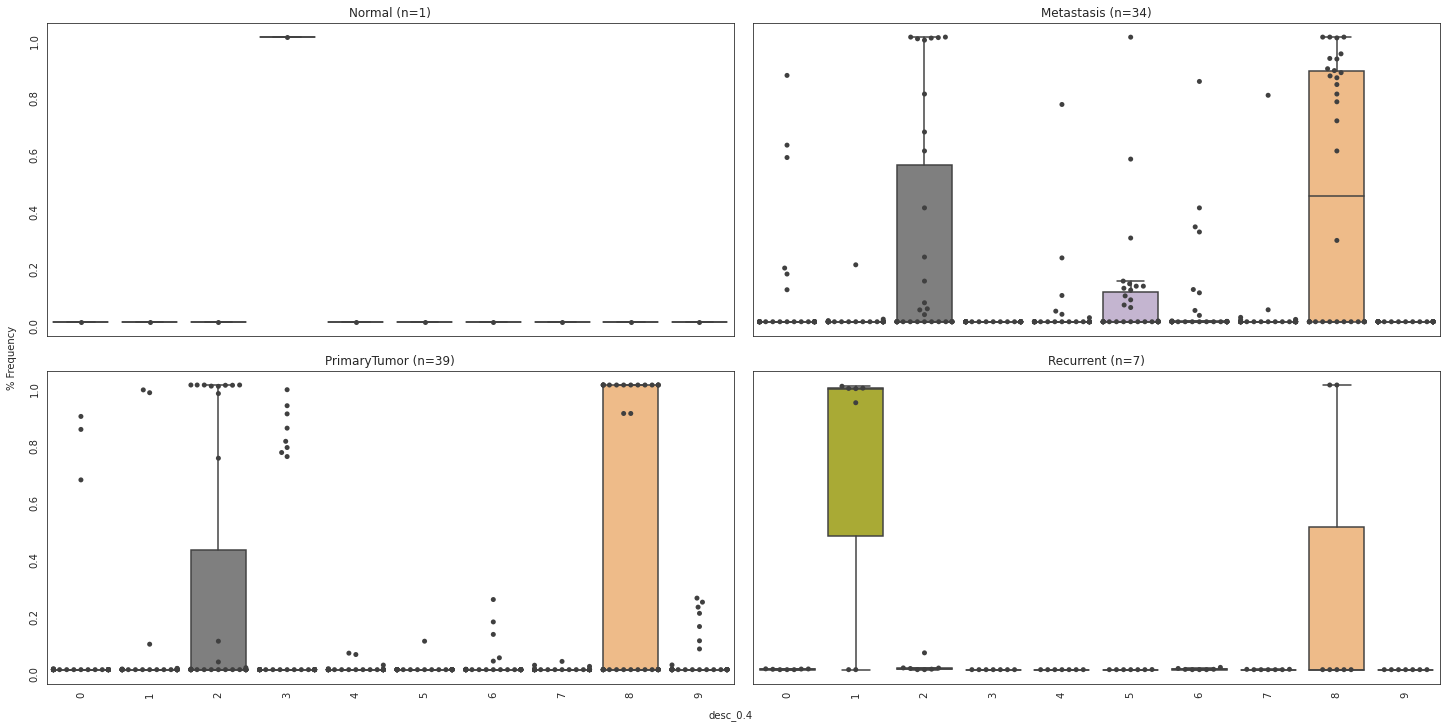

In [81]:
import seaborn as sns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, constrained_layout=True,
                                             figsize=(20,10))
sns.set_style("white")
sns.boxplot(x="Unnamed: 2", y="desc_0.42", data=tmp2.loc[tmp2['Type']== "Normal"], showfliers = False,palette="tab20_r",ax=ax1,order=order_agebin)
sns.swarmplot(x="Unnamed: 2", y="desc_0.42", data=tmp2.loc[tmp2['Type']== "Normal"], color=".25",size=5,ax=ax1,order=order_agebin)
sns.boxplot(x="Unnamed: 2", y="desc_0.42", data=tmp2.loc[tmp2['Type']== "Metastasis"], showfliers = False,palette="tab20_r",ax=ax2,order=order_agebin)
sns.swarmplot(x="Unnamed: 2", y="desc_0.42", data=tmp2.loc[tmp2['Type']== "Metastasis"], color=".25",size=5,ax=ax2,order=order_agebin)
sns.boxplot(x="Unnamed: 2", y="desc_0.42", data=tmp2.loc[tmp2['Type']== "PrimaryTumor"], showfliers = False,palette="tab20_r",ax=ax3,order=order_agebin)
sns.swarmplot(x="Unnamed: 2", y="desc_0.42", data=tmp2.loc[tmp2['Type']== "PrimaryTumor"], color=".25",size=5,ax=ax3,order=order_agebin)
sns.boxplot(x="Unnamed: 2", y="desc_0.42", data=tmp2.loc[tmp2['Type']== "Recurrent"], showfliers = False,palette="tab20_r",ax=ax4,order=order_agebin)
sns.swarmplot(x="Unnamed: 2", y="desc_0.42", data=tmp2.loc[tmp2['Type']== "Recurrent"], color=".25",size=5,ax=ax4,order=order_agebin)
ax1.set_ylabel(" ",fontsize=3)
ax2.set_ylabel(" ",fontsize=3)
ax3.set_ylabel(" ",fontsize=3)
ax4.set_ylabel(" ",fontsize=3)
ax1.set_xlabel(" ",fontsize=3)
ax2.set_xlabel(" ",fontsize=3)
ax3.set_xlabel(" ",fontsize=3)
ax4.set_xlabel(" ",fontsize=3)
ax1.axes.xaxis.set_visible(True)
ax2.axes.xaxis.set_visible(True)
ax1.tick_params(labelrotation=90)
ax2.tick_params(labelrotation=90)
ax3.tick_params(labelrotation=90)
ax4.tick_params(labelrotation=90)
ax1.title.set_text("Normal (n={0})".format(len(tmp2.loc[tmp2['Type']== "Normal"]['SampleID'].unique()) ))
ax2.title.set_text("Metastasis (n={0})".format(len(tmp2.loc[tmp2['Type']== "Metastasis"]['SampleID'].unique()) ))
ax3.title.set_text("PrimaryTumor (n={0})".format(len(tmp2.loc[tmp2['Type']== "PrimaryTumor"]['SampleID'].unique()) ))
ax4.title.set_text("Recurrent (n={0})".format(len(tmp2.loc[tmp2['Type']== "Recurrent"]['SampleID'].unique()) ))
plt.tight_layout()
fig.text(0.5, 0.001, 'desc_0.4', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.001, 0.5, '% Frequency ', va='center', ha='center', rotation='vertical', fontsize=rcParams['axes.labelsize'])
plt.show()

In [82]:
tmp2

,SampleID,Type,Unnamed: 2,desc_0.42,merge
0,2,PrimaryTumor,2,1.0,PrimaryTumor_2
1,2,PrimaryTumor,0,0.0,PrimaryTumor_0
2,2,PrimaryTumor,1,0.0,PrimaryTumor_1
3,2,PrimaryTumor,3,0.0,PrimaryTumor_3
4,2,PrimaryTumor,4,0.0,PrimaryTumor_4
...,...,...,...,...,...
805,ctrl12,Normal,5,0.0,Normal_5
806,ctrl12,Normal,6,0.0,Normal_6
807,ctrl12,Normal,7,0.0,Normal_7
808,ctrl12,Normal,8,0.0,Normal_8


In [83]:
adata2.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Integrated_CD8_RES04.h5ad")

## RES 06

In [91]:
adata2.obsm['X_emb'] = adata2.obsm['X_Embeded_z'+str(0.6)]
run_vis(adata2)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:32)


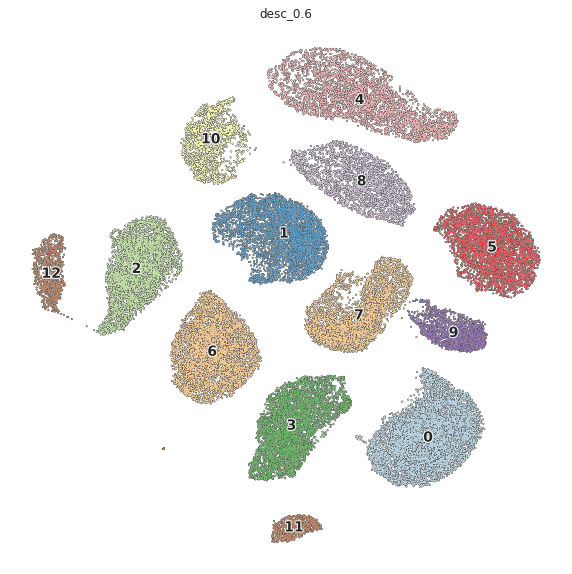

In [93]:
rcParams['figure.figsize'] = 10, 10
sc.pl.umap(adata2, color='desc_0.6', add_outline=True,legend_loc='on data',size=5,
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='desc_0.6')

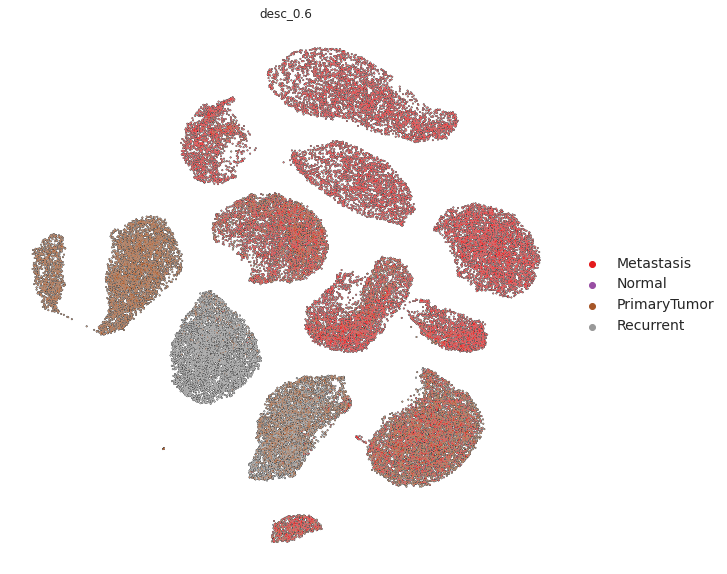

In [110]:
rcParams['figure.figsize'] = 10, 10
sc.pl.umap(adata2, color='Type', add_outline=True,size=5,
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='desc_0.6', palette='Set1')

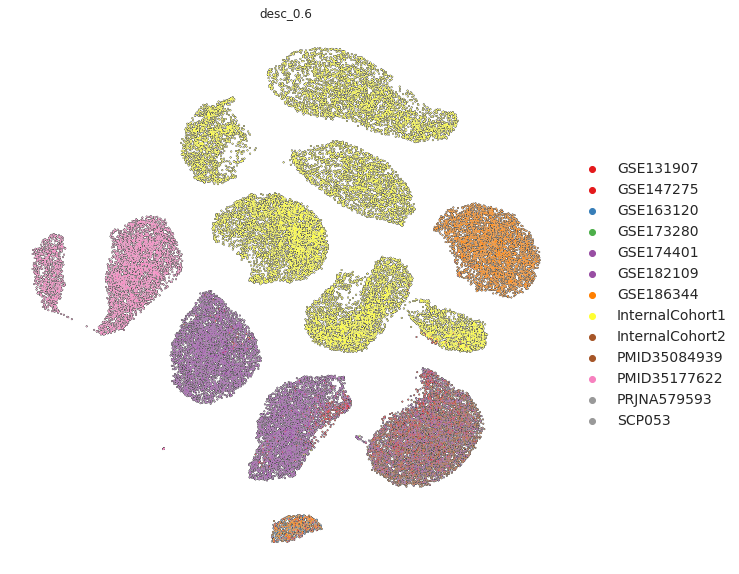

In [111]:
rcParams['figure.figsize'] = 10, 10
sc.pl.umap(adata2, color='Cohort', add_outline=True,size=5,
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='desc_0.6', palette='Set1')

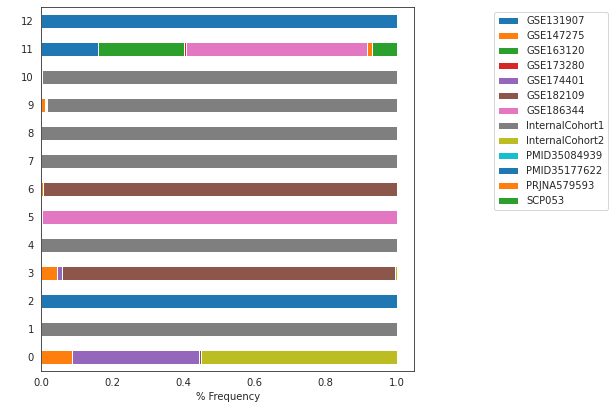

In [97]:
fig, (ax1) = plt.subplots(1,1, figsize=(17/2.54,17/2.54))
ax1 = adata2.obs.groupby("desc_0.6")["Cohort"].value_counts(normalize=True).unstack().plot.barh(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("% Frequency")
ax1.set_ylabel(" ")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))

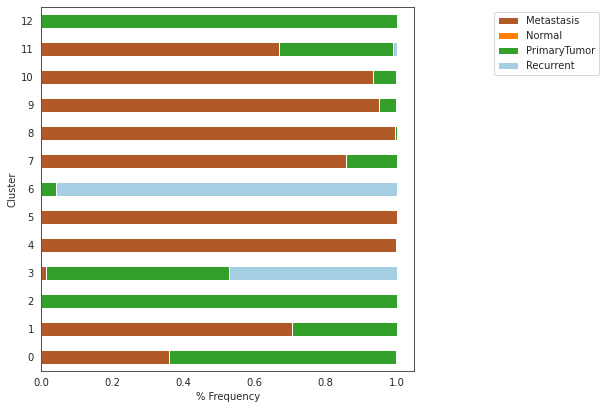

In [98]:
fig, (ax1) = plt.subplots(1,1, figsize=(17/2.54,17/2.54))
ax1 = adata2.obs.groupby("desc_0.6")["Type"].value_counts(normalize=True).unstack().plot.barh(stacked=True,legend=False,ax=ax1,colormap='Paired_r')
ax1.set_xlabel("% Frequency")
ax1.set_ylabel("Cluster")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.2, 1.0))

In [99]:
sc.tl.rank_genes_groups(adata2, 'desc_0.6', method='wilcoxon',use_raw=False,pts=0.20)
pd.DataFrame(adata2.uns['rank_genes_groups']['names']).head(50)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:57)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,B2M,MTRNR2L12,AC016831.7,TMSB4X,SEPTIN7,IGKC,JUND,EEF1G,IFITM1,MTRNR2L12,MTRNR2L12,ATP5L,AC016831.7
1,TMSB4X,RESF1,SIK3,ATP5F1E,IFNG,IGLC3,NEAT1,EEF1A1,ATP6V0C,TNFAIP3,RESF1,GNB2L1,SIK3
2,TRAC,ZFP36,ZSWIM6,SPP1,TIGIT,ATP5E,GZMK,SARAF,PCBP2,RESF1,SEPTIN7,ATP5G2,ARHGAP15
3,RARRES3,PLAAT4,ARIH1,FTL,ITGAE,GNB2L1,SRSF7,MTRNR2L12,GZMB,CXCL13,PLAAT4,ATP5E,DENND4A
4,SEPT7,TLE5,ELL2,UBA52,CTLA4,IGHG1,IER2,FTH1,GAPDH,ZFP36,SEPTIN1,ATP5G3,ARIH1
5,ATP5F1E,HLA-B,DENND4A,RACK1,GZMB,GLTSCR2,CD81,ATP6V0C,HSPA8,RNF19A,TLE5,C19orf43,ZSWIM6
6,MYL12A,SEPTIN9,ARHGAP15,FAU,IFITM1,ATP5L,GZMM,SNHG29,PLAAT4,AHNAK,LINC01578,TCEB2,JMJD1C
7,CD3D,JUND,ARHGAP26,APOE,DUSP4,IGLC2,FOSB,ZFP36,ZFP36L2,IL7R,ACTB,SHFM1,FOXP1
8,TMSB10,PCED1B-AS1,PDE3B,TMSB10,DUSP5,S100A6,GZMH,PABPC1,SNHG29,ETS1,DUSP4,ATP5D,SIPA1L1
9,ATP5MG,LINC01578,ZFAND3,N4BP2L2,RHOB,ATP5G2,GZMA,GAS5,EIF4A1,FYN,RNASEK,ATP5J,CDC42SE2


In [101]:
groups = result['names'].dtype.names
with pd.ExcelWriter('/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/DEGS_CD8_Res06.xlsx') as writer:
    for _ in range(len(groups)):
        sc.get.rank_genes_groups_df(adata2,
                                    group=groups[_], key='rank_genes_groups').to_excel(writer, sheet_name=groups[_],index=False)
        

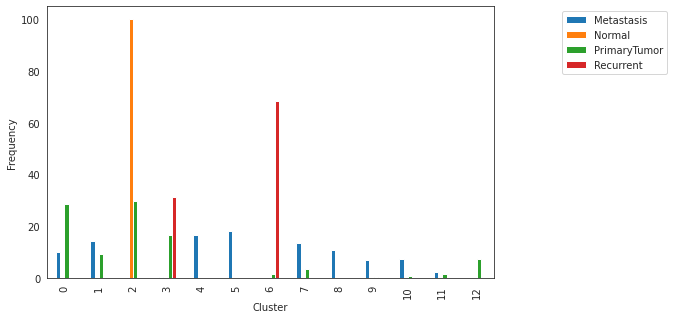

In [102]:
fig, (ax1) = plt.subplots(1,1, figsize=(8,5))
#
ax1 = (pd.crosstab(adata2.obs["desc_0.6"], adata.obs.Type,normalize='columns')*100).plot.bar(stacked=False,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.4, 1.0))

In [103]:
tmp1 = pd.DataFrame(adata2.obs.groupby(["SampleID","Type"])["desc_0.6"].value_counts(normalize=True))

In [104]:
tmp1 = tmp1.rename({'desc_0.6':'desc_0.62'},axis=1)
tmp1.to_csv("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/ptzfreqtreg.csv",sep="\t",index=True,header=True)

In [105]:
tmp2 = pd.read_csv("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/ptzfreqtreg.csv",sep="\t",header=0)

In [106]:
tmp2['merge'] = tmp2['Type'] + "_" + tmp2['Unnamed: 2'].astype(str)

In [107]:
order_agebin = pd.value_counts(tmp2['Unnamed: 2']).sort_index().index

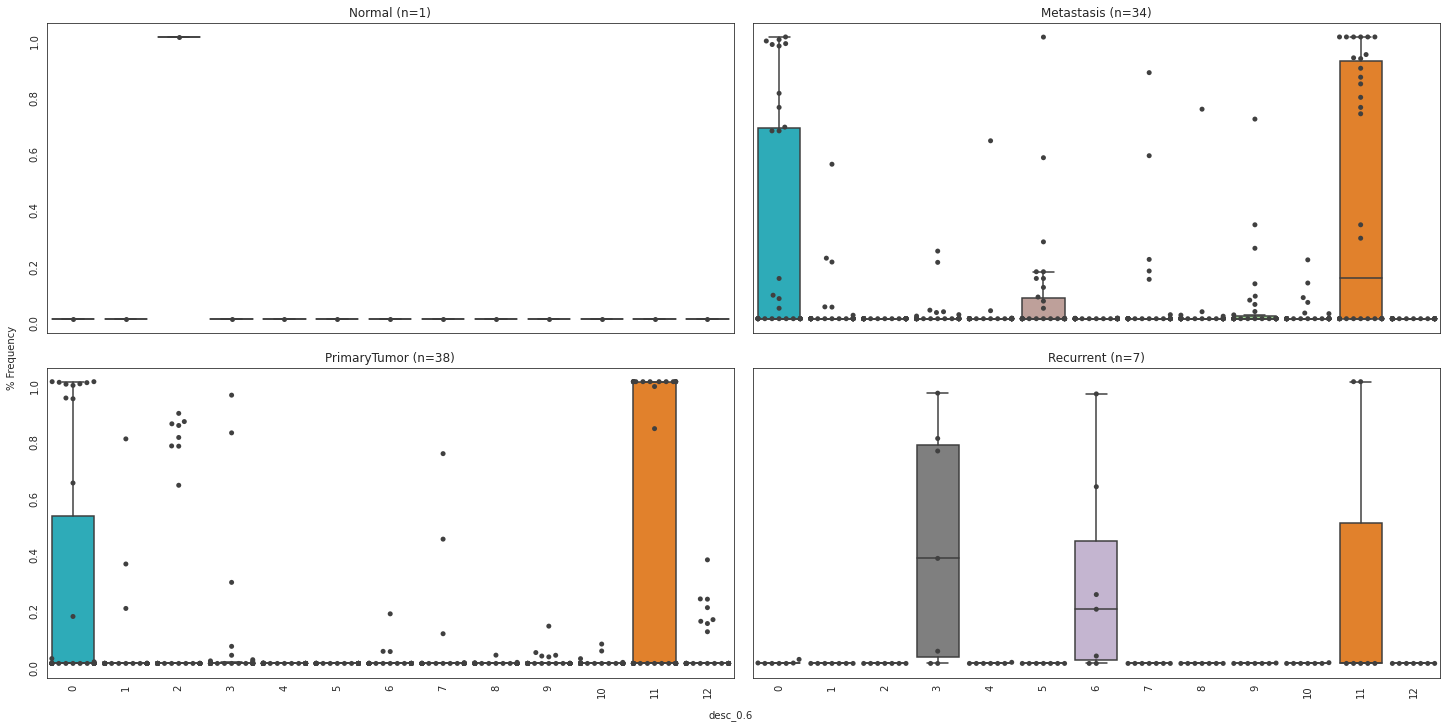

In [108]:
import seaborn as sns
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, constrained_layout=True,
                                             figsize=(20,10))
sns.set_style("white")
sns.boxplot(x="Unnamed: 2", y="desc_0.62", data=tmp2.loc[tmp2['Type']== "Normal"], showfliers = False,palette="tab20_r",ax=ax1,order=order_agebin)
sns.swarmplot(x="Unnamed: 2", y="desc_0.62", data=tmp2.loc[tmp2['Type']== "Normal"], color=".25",size=5,ax=ax1,order=order_agebin)
sns.boxplot(x="Unnamed: 2", y="desc_0.62", data=tmp2.loc[tmp2['Type']== "Metastasis"], showfliers = False,palette="tab20_r",ax=ax2,order=order_agebin)
sns.swarmplot(x="Unnamed: 2", y="desc_0.62", data=tmp2.loc[tmp2['Type']== "Metastasis"], color=".25",size=5,ax=ax2,order=order_agebin)
sns.boxplot(x="Unnamed: 2", y="desc_0.62", data=tmp2.loc[tmp2['Type']== "PrimaryTumor"], showfliers = False,palette="tab20_r",ax=ax3,order=order_agebin)
sns.swarmplot(x="Unnamed: 2", y="desc_0.62", data=tmp2.loc[tmp2['Type']== "PrimaryTumor"], color=".25",size=5,ax=ax3,order=order_agebin)
sns.boxplot(x="Unnamed: 2", y="desc_0.62", data=tmp2.loc[tmp2['Type']== "Recurrent"], showfliers = False,palette="tab20_r",ax=ax4,order=order_agebin)
sns.swarmplot(x="Unnamed: 2", y="desc_0.62", data=tmp2.loc[tmp2['Type']== "Recurrent"], color=".25",size=5,ax=ax4,order=order_agebin)
ax1.set_ylabel(" ",fontsize=3)
ax2.set_ylabel(" ",fontsize=3)
ax3.set_ylabel(" ",fontsize=3)
ax4.set_ylabel(" ",fontsize=3)
ax1.set_xlabel(" ",fontsize=3)
ax2.set_xlabel(" ",fontsize=3)
ax3.set_xlabel(" ",fontsize=3)
ax4.set_xlabel(" ",fontsize=3)
ax1.axes.xaxis.set_visible(True)
ax2.axes.xaxis.set_visible(True)
ax1.tick_params(labelrotation=90)
ax2.tick_params(labelrotation=90)
ax3.tick_params(labelrotation=90)
ax4.tick_params(labelrotation=90)
ax1.title.set_text("Normal (n={0})".format(len(tmp2.loc[tmp2['Type']== "Normal"]['SampleID'].unique()) ))
ax2.title.set_text("Metastasis (n={0})".format(len(tmp2.loc[tmp2['Type']== "Metastasis"]['SampleID'].unique()) ))
ax3.title.set_text("PrimaryTumor (n={0})".format(len(tmp2.loc[tmp2['Type']== "PrimaryTumor"]['SampleID'].unique()) ))
ax4.title.set_text("Recurrent (n={0})".format(len(tmp2.loc[tmp2['Type']== "Recurrent"]['SampleID'].unique()) ))
plt.tight_layout()
fig.text(0.5, 0.001, 'desc_0.6', va='center', ha='center', fontsize=rcParams['axes.labelsize'])
fig.text(0.001, 0.5, '% Frequency ', va='center', ha='center', rotation='vertical', fontsize=rcParams['axes.labelsize'])
plt.show()

In [109]:
adata2.write("/home/lugli/spuccio/Projects/SP039/FileH5AD_concatenated/Integrated_CD8_RES06.h5ad")